# &#x1F4D1; &nbsp; Mixed Styles
## Style, Links and Libraries
[`Artistic Style Transfer. Naoki Shibuya`](https://github.com/naokishibuya/deep-learning/blob/master/python/artistic_style_transfer.ipynb)

[`Deep Learning with R. François Chollet, J.J. Allaire`](https://github.com/jjallaire/deep-learning-with-r-notebooks)

In [51]:
library(IRdisplay)
library(repr)
library(tensorflow)
library(keras)
library(imager)
library(R6)

In [19]:
keras_backend <- backend()

In [7]:
display_html("<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;} 
</style>")

## Chose and Display Images

In [79]:
original_file <- "art_images/16.png"
style_file <- "art_images/12.png"

[1] 401 401   1   4

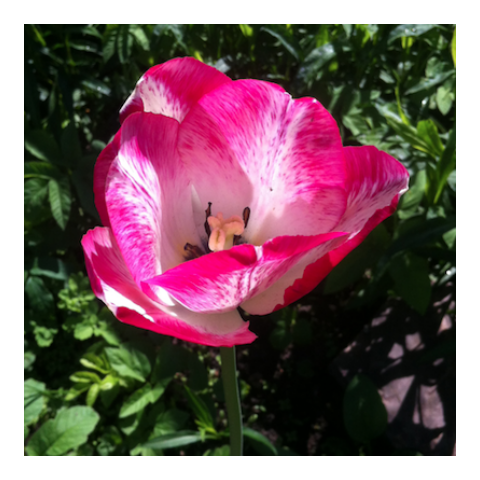

In [80]:
original <- load.image(original_file)
options(repr.plot.width=4,repr.plot.height=4)
par(mar=c(1,1,1,1))
dim(original)
plot(original,axes=F)

[1] 450 437   1   3

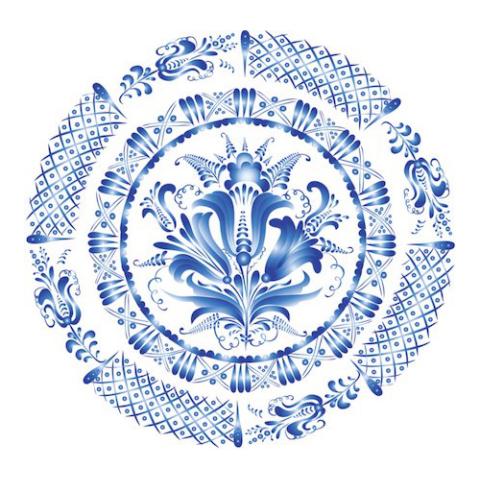

In [81]:
style <- load.image(style_file)
options(repr.plot.width=4,repr.plot.height=4)
par(mar=c(1,1,1,1))
dim(style)
plot(style,axes=F)

## Preprocess

In [82]:
original_image <- image_load(original_file)
original_width <- original_image$size[[1]]
original_height <- original_image$size[[2]]
original_image_nrows <- 400
original_image_ncols <- as.integer(original_width * original_image_nrows / original_height)  

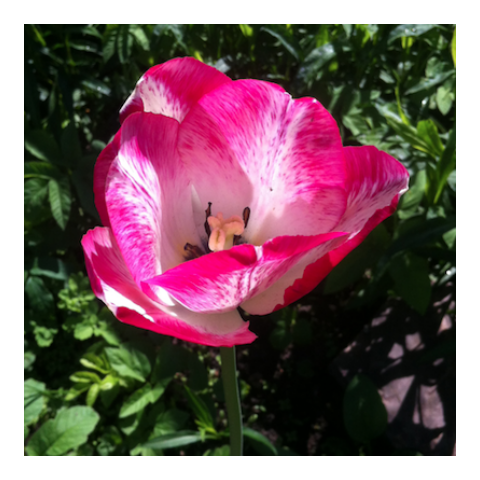

In [83]:
par(mar=c(1,1,1,1))
plot(as.raster(image_to_array(original_image)/255))

In [84]:
preprocess_image <- function(file) {
  image <- image_load(file,target_size=c(original_image_nrows,original_image_ncols)) %>%
    image_to_array() %>%
    array_reshape(c(1, dim(.)))
  return(imagenet_preprocess_input(image))
}

deprocess_image <- function(x) {
  x <- x[1,,,]
  # Remove zero-center by mean pixel
  x[,,1] <- x[,,1] + 103.939
  x[,,2] <- x[,,2] + 116.779
  x[,,3] <- x[,,3] + 123.68
  # bgr ⟹ rgb
  x <- x[,,c(3,2,1)]
  x[x > 255] <- 255
  x[x < 0] <- 0
  x[] <- as.integer(x) / 255
  return(x)
}

In [85]:
original_image <- keras_backend$constant(preprocess_image(original_file))
style_image <- keras_backend$constant(preprocess_image(style_file))

transfer_image <- keras_backend$placeholder(c(1L,original_image_nrows,original_image_ncols,3L)) 
input_tensor <- keras_backend$concatenate(list(original_image,style_image,transfer_image),axis=0L)

## VGG16 Usage

In [86]:
model <- application_vgg19(input_tensor=input_tensor, 
                           weight="imagenet", 
                           include_top=FALSE)
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_2 (InputLayer)                (None, None, None, 3)           0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, None, None, 64)          1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, None, None, 64)          36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, None, None, 64)          0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, None, None, 128)         73856       
________________________________________________________________________________
block2_conv2 (Conv2D)       

In [87]:
original_loss <- function(original,transfer) {keras_backend$sum(keras_backend$square(transfer - original))}

In [88]:
gram_matrix <- function(x) {
  features <- keras_backend$batch_flatten(keras_backend$permute_dimensions(x,list(2L,0L,1L)))
  return(keras_backend$dot(features,keras_backend$transpose(features)))
}

In [89]:
style_loss <- function(style,transfer){
  channels <- 3
  size <- original_image_nrows * original_image_ncols
  return(keras_backend$sum(keras_backend$square(gram_matrix(style) - gram_matrix(transfer))) / 
         (4 * channels^2  * size^2))
}

In [90]:
variation_loss <- function(x) {
  y_ij  <- x[,1:(original_image_nrows - 1L),1:(original_image_ncols - 1L),]
  y_i1j <- x[,2:(original_image_nrows),1:(original_image_ncols - 1L),]
  y_ij1 <- x[,1:(original_image_nrows - 1L), 2:(original_image_ncols),]
  row_diff <- keras_backend$square(y_ij - y_i1j)
  col_diff <- keras_backend$square(y_ij - y_ij1)
  return(keras_backend$sum(keras_backend$pow(row_diff + col_diff, 1.25)))
}

In [91]:
layers_dict <- lapply(model$layers, `[[`, "output")
names(layers_dict) <- lapply(model$layers, `[[`, "name")

original_layer <- "block5_conv2" 
style_layers = c("block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1")

In [92]:
original_weight <- 0.025
style_weight <- 1.0
variation_weight <- 1e-4

In [93]:
loss <- keras_backend$variable(0.0) 

layer_features <- layers_dict[[original_layer]] 
original_features <- layer_features[1,,,]
transfer_features <- layer_features[3,,,]

loss <- loss + original_loss(original_features,transfer_features) * original_weight

In [94]:
for (layer_name in style_layers){
  layer_features <- layers_dict[[layer_name]]
  style_features <- layer_features[2,,,]
  transfer_features <- layer_features[3,,,]

  loss <- loss + style_loss(style_features,transfer_features) * (style_weight / length(style_layers))
}

In [95]:
loss <- loss + variation_loss(transfer_image) * variation_weight

In [96]:
gradients <- keras_backend$gradients(loss,transfer_image)[[1]] 

fetch_loss_and_gradients <- keras_backend$`function`(list(transfer_image),list(loss, gradients))

evaluate_loss_and_gradients <- function(image) {
  image <- array_reshape(image, c(1,original_image_nrows,original_image_ncols,3))
  outputs <- fetch_loss_and_gradients(list(image))
  return(list(
    loss_value = outputs[[1]],
    gradient_values = array_reshape(outputs[[2]],dim=length(outputs[[2]]))
  ))
}

In [97]:
Evaluator <- R6Class("Evaluator",
  public = list(
    
    loss_value = NULL,
    gradient_values = NULL,
    
    initialize = function() {
      self$loss_value <- NULL
      self$gradient_values <- NULL
    },
    
    loss = function(x){
      loss_and_gradients <- evaluate_loss_and_gradients(x)
      self$loss_value <- loss_and_gradients$loss_value
      self$gradient_values <- loss_and_gradients$gradient_values
      self$loss_value
    },
    
    gradients = function(x){
      gradient_values <- self$gradient_values
      self$loss_value <- NULL
      self$gradient_values <- NULL
      gradient_values
    }
  )
)

evaluator <- Evaluator$new()

## Display Style Transfer

In [98]:
iterations <- 20
dimensions <- c(1,original_image_nrows,original_image_ncols,3)

x <- preprocess_image(original_file)
x <- array_reshape(x,dim=length(x))

Loss: 36650860544 
Loss: 13426989056 


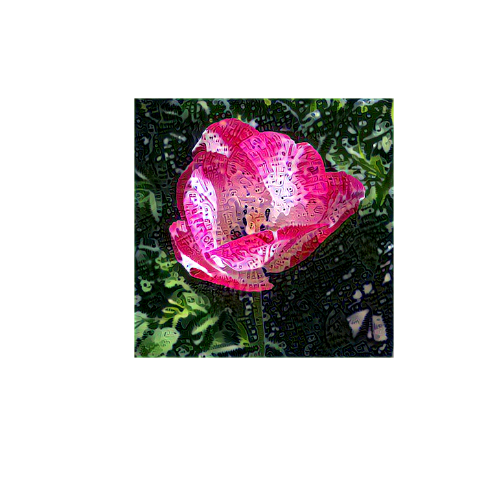

Loss: 7712999424 


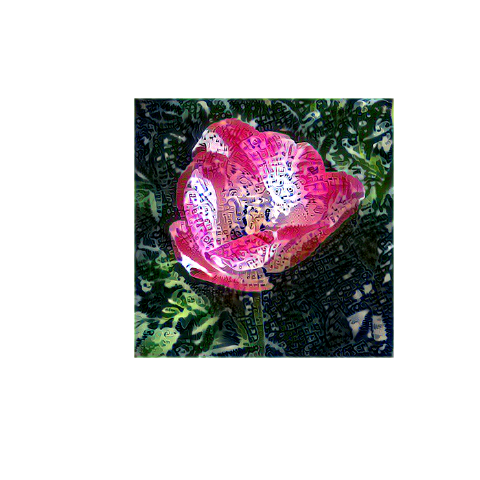

Loss: 5583730176 


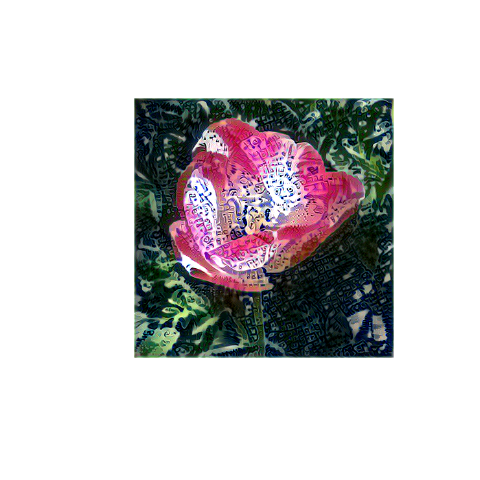

Loss: 4559709184 


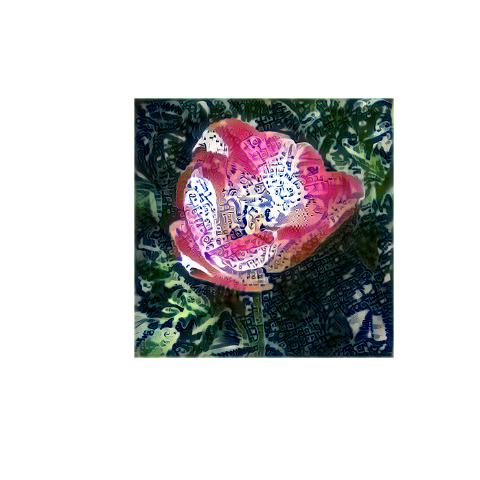

Loss: 4018290432 


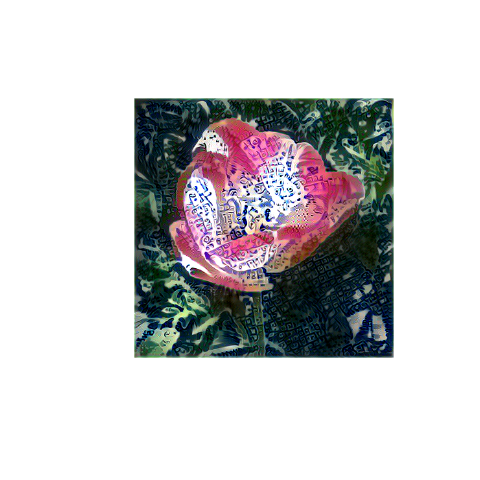

Loss: 3542119936 


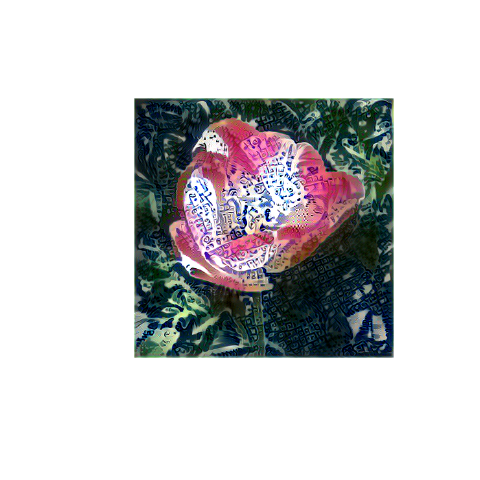

Loss: 3192334336 


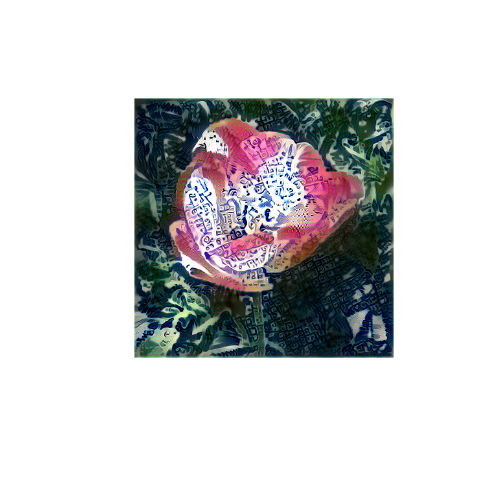

Loss: 2942485248 


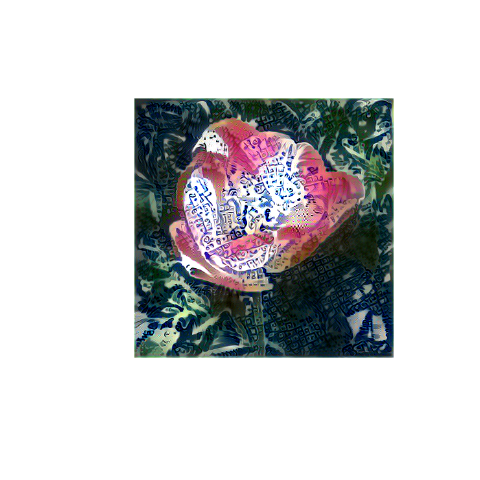

Loss: 2734598912 


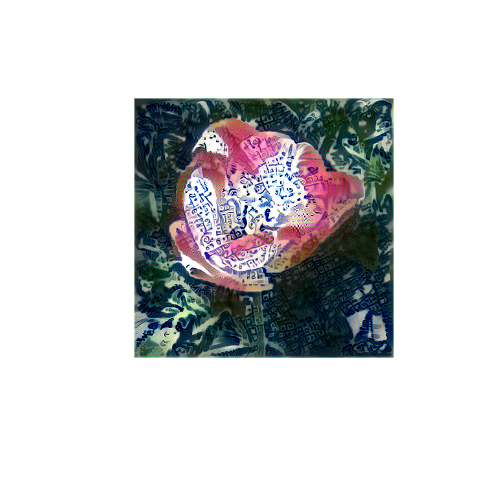

Loss: 2566859520 


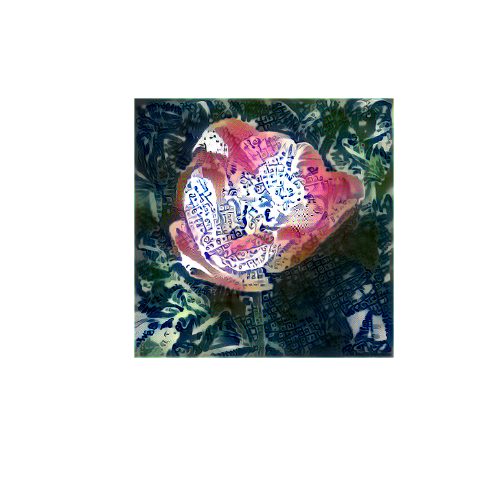

Loss: 2401778944 


In [ ]:
for (i in 1:iterations) { 
  
  # Run L-BFGS
  opt <- optim(
    array_reshape(x, dim=length(x)), 
    fn = evaluator$loss, 
    gr = evaluator$gradients, 
    method = "L-BFGS-B",
    control = list(maxit=15)
  )
  
  cat("Loss:", opt$value, "\n")
  
  image <- x <- opt$par
  image <- array_reshape(image,dimensions)
  
  im <- deprocess_image(image)
  plot(as.raster(im))
}